# Translation pipeline

In [ ]:
import pandas as pd
from datasets import Dataset
from preprocessing_utils import concat_course_info
from translator import Translator

# Load the data
df = pd.read_csv("../scraper/data/course_data.csv")

# Apply the concatenation function
df["course_description"] = df.apply(concat_course_info, axis=1)

# Create a dataset
dataset = Dataset.from_pandas(df.sample(20))

# Apply the translation pipeline
translator = Translator(model_name="Helsinki-NLP/opus-tatoeba-fi-en")
dataset = translator.translate_dataset(dataset, "course_description")

# Save the dataset
#dataset = dataset.remove_columns(["__index_level_0__"])
#dataset.to_parquet("translated_course_data.parquet")

# Reading the translated dataset

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
df = pd.read_csv("translated_course_data_V2.csv")

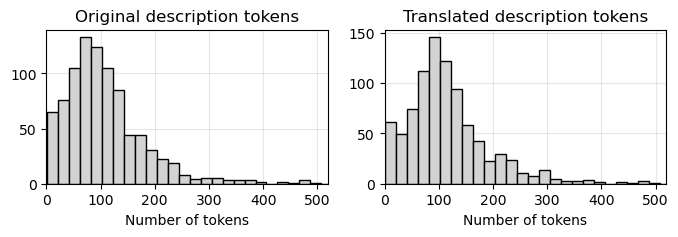

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 2))
# Calculate the length of the course descriptions in tokens (course_description_en)
df["course_description"].str.split().apply(len).hist(
    bins=50,
    ax=ax[0],
    color="lightgray",
    edgecolor="black",
)
df["course_description_en"].str.split().apply(len).hist(
    bins=50,
    ax=ax[1],
    color="lightgray",
    edgecolor="black",
)

ax[0].set_title("Original description tokens")
ax[1].set_title("Translated description tokens")

for i in range(2):
    ax[i].set_xlim([0, 520])
    ax[i].grid(alpha=0.3)
    ax[i].set_axisbelow(True)
    ax[i].set_xlabel("Number of tokens")

plt.show()

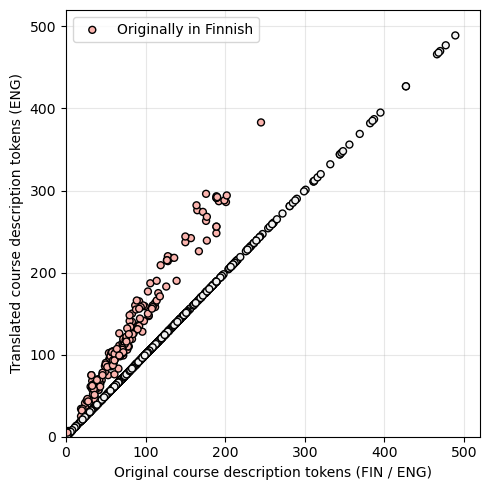

In [5]:
# Plot a scatterplot of course_description token length and course_description_en token length
import matplotlib.pyplot as plt

label = 1 * (df["course_description"].str.split().apply(len) == df["course_description_en"].str.split().apply(len))

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(
    df["course_description"].str.split().apply(len),
    df["course_description_en"].str.split().apply(len),
    edgecolor="black",
    s=25,
    c=label,
    cmap="Pastel1",
)

ax.set_xlim([0, 520])
ax.set_ylim([0, 520])
ax.set_xlabel("Original course description tokens (FIN / ENG)")
ax.set_ylabel("Translated course description tokens (ENG)")
ax.grid(alpha=0.3)
ax.set_axisbelow(True)
ax.legend(["Originally in Finnish"], loc="upper left")

fig.tight_layout()
plt.show()

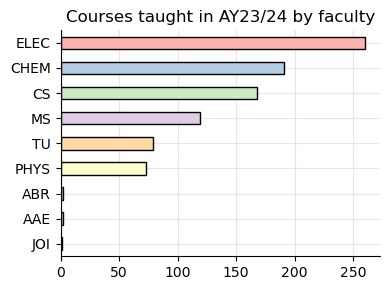

In [68]:
faculty = df["course_code"].str.split("-", expand=True)[0]
fig, ax = plt.subplots(figsize=(4, 3))
faculty.value_counts().plot(
    kind="barh",
    edgecolor="black",
    color="lightgray",
    ax=ax,
)

# Assign individual colors to each bar
for i, bar in enumerate(ax.patches):
    bar.set_facecolor(plt.cm.Pastel1(i / 9))

ax.invert_yaxis()
ax.set_title("Courses taught in AY23/24 by faculty")
ax.grid(alpha=0.3)
ax.set_axisbelow(True)
sns.despine()

fig.tight_layout()
plt.show()

# tf-idf

In [7]:
from tfidf import calculate_tf_idf
X, vectorizer = calculate_tf_idf(df, "course_description_en")

# Represent the courses in 2D

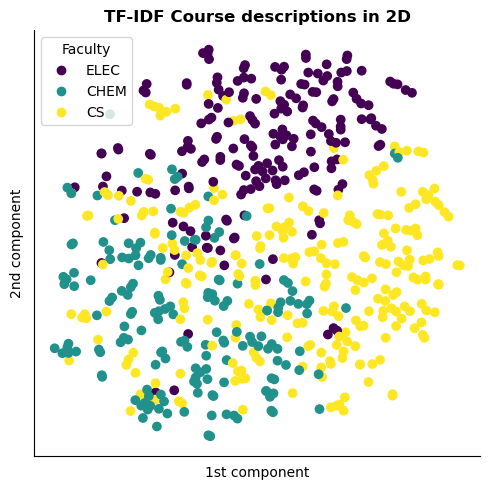

In [11]:
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE

# Keep the top 3 faculties
top_faculties = faculty.value_counts().index[:3]
mask = faculty.isin(top_faculties)
X_masked = X[mask].toarray()


reduced = TSNE(
    n_components=2,
    perplexity=40,
    n_iter=5000,
).fit_transform(X_masked)

# Faculty labels
_, faculty_labels = np.unique(faculty[mask].values, return_inverse=True)


# Plot
fig, ax = plt.subplots(figsize=(5, 5))
scatter = ax.scatter(
    reduced[:, 0],
    reduced[:, 1],
    c=faculty_labels,
)

# Legend
legend1 = ax.legend(
    scatter.legend_elements()[0],
    top_faculties,
    title="Faculty",
)

sns.despine()
ax.grid(alpha=0.2)
ax.set_axisbelow(True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("TF-IDF Course descriptions in 2D", fontweight="bold")
ax.set_xlabel("1st component")
ax.set_ylabel("2nd component")

fig.tight_layout()
plt.show()

In [35]:
faculty.unique()

array(['CHEM', 'MS', 'CS', 'ELEC', 'TU', 'PHYS', 'ABR', 'AAE', 'JOI'],
      dtype=object)

# TF-IDF IR

In [76]:
import numpy as np
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity


stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))
stop_words.update(punctuation)
stop_words.add("...")

def top_k_tfidf(query, k=5):
    query = word_tokenize(query)
    query = [stemmer.stem(word) for word in query if word.lower() not in stop_words and word.isalnum()]
    query = " ".join(query)

    print(f"Transformed {query=}")

    # Calculate the cosine similarity and sort the results
    cosine_sim = cosine_similarity(X, vectorizer.transform([query]))
    cosine_sim = cosine_sim.flatten()
    cosine_sim = np.argsort(cosine_sim)[::-1]

    # Print the top 5 most similar courses
    return df.iloc[cosine_sim[:k]][["course_code", "course_name", "course_description_en"]]

top_k_tfidf("I want to learn strategy and machine learning", k=5)

Transformed query='want learn strategi machin learn'


,course_code,course_name,course_description_en
650,CS-E4710,Machine Learning: Supervised Methods D,"Machine Learning: Supervised Methods D. After the course, the student knows how to recognize and formalize supervised machine learning problems, how to implement basic optimization algorithms for supervised learning problems, how to evaluate the performance supervised machine learning models, and has understanding of the statistical and computational limits of supervised machine learning, as well as the principles behind commonly used machine learning models.Generalization error analysis and estimation; Model selection; Optimization and computational complexity; Linear models; Support vector machines and kernel methods; Boosting; Feature selection and sparsity; Multi-layer perceptrons; Multi-class classification; Preference learning"
327,ELEC-E8749,Machine learning project in Health Technologies,Machine learning project in Health Technologies.
5,CS-E407519,"Special Course in Machine Learning, Data Science and Artificial Intelligence: Machine Learning for Climate Action","Special Course in Machine Learning, Data Science and Artificial Intelligence: Machine Learning for Climate Action. The purpose of this special course is to demonstrate how machine learning methods can be used to tackle climate change."
195,ELEC-C5220,Koneoppiminen informaatioteknologiassa,"Machine Learning in Information Technology. After taking the course You will know the general principles and concepts of machine learning, especially neural networks and deep learning, and their key methods You will be able to apply what you have learned to some real-world problems in applications of information technology, especially speech technology, signal processing and telecommunications technology You will be able to describe the problems of machine learning in speech technology, signal processing and communication technology"
566,CS-EJ3311,Deep Learning with Python D,"Deep Learning with Python D. Intended as follow-up for CS-EJ3211 Machine Learning with Python.In this course, you will learn how to use state-of-the-art deep learning methods with the programming language Python. We will discuss key concepts of deep learning, such as artificial neural networks, data augmentation and transfer learning in a hands-on fashion. The grading is based on coding assignments and student projects."
